In [1]:
%load_ext autoreload
%autoreload 2

Import packages

In [2]:
import conceptlab as clab
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import anndata as ad
import scanpy as sc
import torch
from omegaconf import OmegaConf

import pytorch_lightning as pl
from lightning.pytorch.loggers import WandbLogger
import wandb

In [3]:
DATA_PATH = '../../data/scgen/curated/kang.h5ad'
MODEL_PATH = '../../results/model_params/kang_model_params.pth'

In [4]:
USE_SAVED_MODEL = True
OVERWRITE_SAVED_MODEL = False

Load data

In [5]:
adata = ad.read_h5ad(DATA_PATH)

Setup model

In [6]:
concept_key = 'concepts'
n_concepts = adata.obsm[concept_key].shape[1]

config_dict = dict(has_cbm = True, 
                       lr = 5e-4,
                       hidden_dim = 256,
                       beta = 1e-5,
                       input_dim = adata.shape[1],
                       latent_dim = 128,
                       n_concepts = n_concepts,
                       min_bottleneck_size = 128, # important
                       independent_training = True,
                       concepts_hp = 0.005,
                       orthogonality_hp = 0.2, # important
                       use_soft_concepts = False,
                      )
    
model_type = clab.models.scCBGM


config = OmegaConf.create(config_dict)

model = model_type(config)

Setup analysis

In [7]:
labels = adata.obs['cell_stim'] # labels to use
hold_out_label = 'CD4 T cells_stim' # label of cells to be held out
mod_label = 'CD4 T cells_ctrl' # label of cells to be modified

Set random seeds

In [8]:
np.random.seed(69)
torch.manual_seed(69)

Split into train, intervention, and reference (test) sets

In [9]:
is_test = np.isin(labels.values, [hold_out_label])
is_inter = np.isin(labels.values, mod_label)
inter_mask = np.random.binomial(1,
                                p=0.2, # important, keep quite low to have enough training data
                                size = len(is_inter)).astype(bool)
is_inter = is_inter * inter_mask
is_train = ~is_test & ~is_inter

Normalize data

In [10]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

Split data. We will train on `adata_train`, intervene on `adata_inter` and compare with `adata_test`.

In [11]:
adata_train = adata[is_train].copy()
adata_test  = adata[is_test].copy()
adata_inter=  adata[is_inter].copy()

Setup data module

In [12]:
data_module = clab.data.dataloader.GeneExpressionDataModule(
        adata_train,
        add_concepts=True,
        concept_key='concepts',
        batch_size=512,
        normalize=False,
    )

initialize logger

In [13]:
if not USE_SAVED_MODEL:
    wandb_logger = WandbLogger(
            project='zero_shot_demo_002',
            log_model=False,
        )

Configure trainer

In [14]:
if not USE_SAVED_MODEL:
    trainer = pl.Trainer(
            max_epochs=200,
            logger=wandb_logger,
            callbacks=[pl.callbacks.RichProgressBar()],
             log_every_n_steps = 10,
        )


Fit model

In [15]:
if not USE_SAVED_MODEL:
    trainer.fit(model, data_module,)
    if OVERWRITE_SAVED_MODEL: torch.save(model.state_dict(), MODEL_PATH )
else:
    model.load_state_dict(torch.load(MODEL_PATH))
    

/tmp/ipykernel_802438/2798235864.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


Move model to CPU and put in eval mode

In [16]:
model.to("cpu")
model.eval()

scCBGM(
  (_encoder): DefaultEncoderBlock(
    (encoder_layers): Sequential(
      (0): Linear(in_features=9224, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (fc_mu): Linear(in_features=256, out_features=128, bias=True)
    (fc_var): Linear(in_features=256, out_features=128, bias=True)
  )
  (cb_concepts_layers): Sequential(
    (0): Linear(in_features=128, out_features=9, bias=True)
    (1): Sigmoid()
  )
  (cb_unk_layers): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
  )
  (_decoder): SkipDecoderBlock(
    (decoder_layers): Sequential(
      (0): SkipLayer(
        (fc): Linear(in_features=137, out_features=256, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (1): SkipLayer(
        (fc): Linear(in_features=265, out_features=9224, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.0, inplace=False)
)

Get data to intervene on (the model has never seen these cells)

In [17]:
x_intervene_on = adata_inter.X.toarray().astype(np.float32).copy()
c_intervene_on =  adata_inter.obsm['concepts'].values.astype(np.float32).copy()

Intervene on the stim concept (last) setting it to zero for all the cells in the intervention data

In [18]:
# create intervention mask
mask = np.zeros_like(c_intervene_on)
inter_concepts = c_intervene_on.copy()
# define which concept should be intervened on and to what value
inter_concepts[:,-1] = 1
mask[:,-1] = 1

# to tensor
mask = torch.tensor(mask.astype(np.float32))
inter_concepts = torch.tensor(inter_concepts.astype(np.float32))

# perform intervention
inter_preds = model.intervene(torch.tensor(x_intervene_on), mask = mask, concepts= inter_concepts)

# get predicted gene expression
x_inter_preds = inter_preds['x_pred'].detach().cpu().numpy()

Create anndata object of predicted data

In [19]:
adata_pred = ad.AnnData(x_inter_preds,
                        var = adata_inter.var,
                        obs = pd.DataFrame(dict(cell_stim = [hold_out_label + '*'] * len(x_inter_preds),
                                                generated = ['yes'] * len(x_inter_preds),
                                                stim = ['stim'] * len(x_inter_preds),
                                                cell = ['CD4 T cells'] * len(x_inter_preds),
                                                 ),
                                          ),
                       )

/gpfs/scratchfs01/site/u/andera29/micromamba/envs/conceptlab/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Add "generated" indicator to original data (includes train and test, does not include intervene)

In [20]:
adata.obs['generated'] = ['no'] * len(adata)

Add indicators to original data

In [21]:
ident_vec = np.array(['train'] * len(adata)).astype('<U32')
ident_vec[is_test] = 'held out as GT'
ident_vec[is_inter] = 'held out for intervention'

adata.obs['ident'] = ident_vec

Add indicator to predicted data

In [22]:
adata_pred.obs['ident'] = 'intervened on'

Merge predicted and original data

In [23]:
adata_merge = ad.concat((adata, adata_pred))

Subset data for faster plotting (True/False)

In [24]:
subset = False

if subset:
    rix = np.random.choice(len(adata_merge), replace = False, size = 5000)
    sub_adata = adata_merge[rix].copy()
else:
    sub_adata = adata_merge

In [25]:
sc.pp.pca(sub_adata)
sc.pp.neighbors(sub_adata)
sc.tl.umap(sub_adata, random_state=69)

Order categories for plotting

In [26]:
sub_adata.obs['ident'] = pd.Categorical(sub_adata.obs['ident'] ,
                                        categories=['train',
                                                    'held out for intervention',
                                                    'held out as GT',
                                                    'intervened on'])

Custom Plot

In [27]:
ct_cmap = {'B cells': '#c80000',
         'CD4 T cells': '#048757',
         'CD8 T cells': '#9cdb97',
         'CD14+ Monocytes': '#90e0ef',
         'Dendritic cells': '#ffb72a',
         'FCGR3A+ Monocytes': '#b18bda',
         'Megakaryocytes': '#c5c5b6',
         'NK cells': '#51696c'}

stim_cmap = {'ctrl' : '#fcb6b1',
             'stim' : '#c44536',
            }

ident_cmap = {'train' : '#676765' ,
              'held out for intervention' : '#c84639',
              'held out as GT' : '#048757',
              'intervened on' : '#06d400'}

title_map = {'cell' : 'Cell Type', 'stim' : 'State', 'ident' : 'Split'}

Plot Results (Figure 1)

/tmp/ipykernel_802438/4073372265.py:60: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Reduce horizontal and vertical spacing


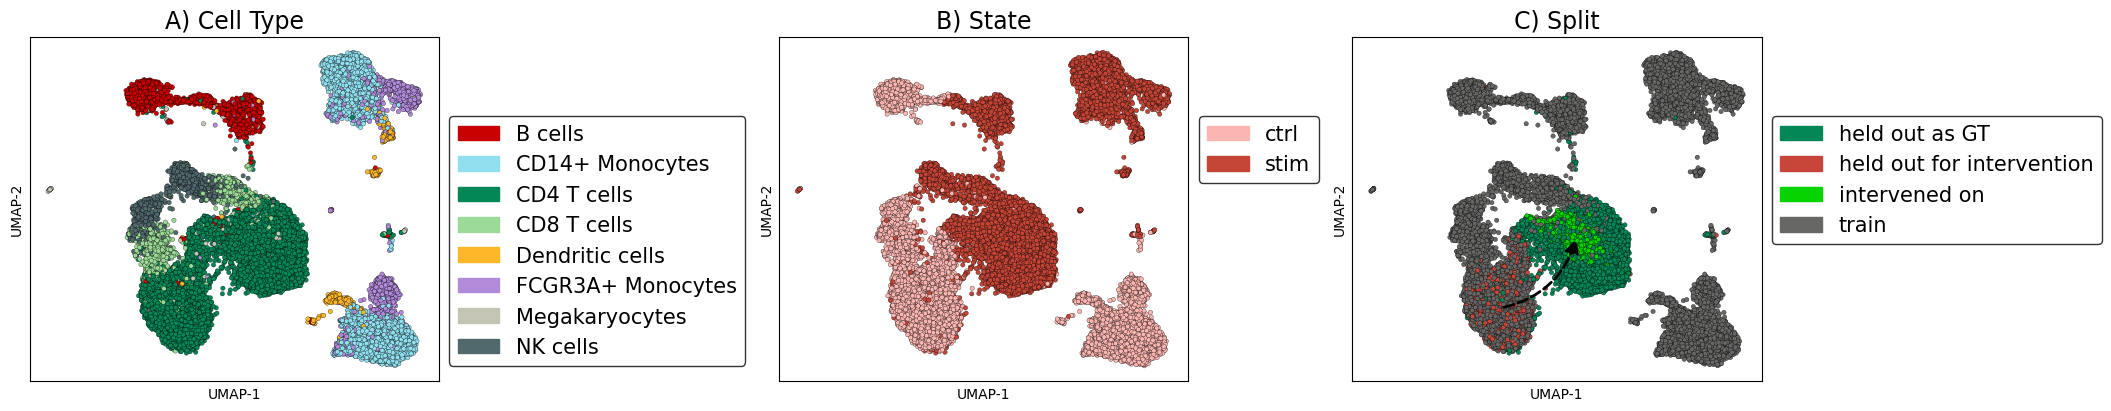

In [28]:
import matplotlib.patches as mpatches
import matplotlib.patches as patches
import string


fig, ax = plt.subplots(1, 3, figsize=(21, 4), constrained_layout = True)
#for k,color in enumerate([ 'cell', 'stim', 'ident']):
for k,(color,cmap) in enumerate(zip([ 'cell', 'stim', 'ident'],[ct_cmap, stim_cmap, ident_cmap])):

    emb_x,emb_y = sub_adata.obsm['X_umap'][:,0], sub_adata.obsm['X_umap'][:,1]
    labels = sub_adata.obs[color].values
    colors = np.array([cmap[lab] for lab in labels])

    rix = np.arange(colors.shape[0])
    np.random.shuffle(rix)


    
    ax[k].scatter(emb_x[rix],
                  emb_y[rix],
                  c = colors[rix],
                  s=10,
                  edgecolor = 'black',
                  linewidth = 0.2,
                  )

    # Add legend based on ct_cmap
    handles = [mpatches.Patch(color=cmap[label], label=label) 
               for label in np.unique(labels)]
    
    legend = ax[k].legend(handles=handles, fontsize=15, bbox_to_anchor=(1.0, 0.8))
    legend.get_frame().set_edgecolor("black")
    ax[k].set_title(f"{string.ascii_uppercase[k]}) {title_map[color]}", fontsize = 17)
    
    ax[k].set_xticks([])
    ax[k].set_yticks([])
    ax[k].set_xlabel('UMAP-1')
    ax[k].set_ylabel('UMAP-2')

    
    if color == 'ident':
        source_ix = labels == 'held out for intervention'
        target_ix = labels == 'intervened on'
        center_source = (emb_x[source_ix].mean(),emb_y[source_ix].mean())
        center_target = (emb_x[target_ix].mean(),emb_y[target_ix].mean())

        arrow = patches.FancyArrowPatch(
                                        center_source, center_target,  # Start and end points
                                        connectionstyle="arc3,rad=0.3",  # Controls curvature (rad=0.3 defines the radius)
                                        arrowstyle="-|>",  # Arrow head style
                                        linewidth=2,
                                        linestyle = 'dashed',
                                        color="black",
                                         mutation_scale=20,
        )

        ax[k].add_patch(arrow)

        
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Reduce horizontal and vertical spacing
#fig.tight_layout()